### Imports and load yeast dataset.

In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Pad, RandomCrop, RandomHorizontalFlip, Normalize
from torch.utils.data import random_split, DataLoader
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping

# Define a custom transform that resizes and pads images to ensure they are 30x30 pixels
custom_transform = Compose([
    Resize((30, 30)),  # This resizes to 30x30 directly 
    ToTensor()
])

# Load dataset with custom transform
dataset = ImageFolder('yeast-class', transform=custom_transform)


### Split dataset into training and validation sets.

In [17]:
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])




### Add GPU support for faster training. The Metal Perforamce Shaders (MPS) are used for GPU acceleration.

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
   
device = get_default_device()
device 

device(type='mps')

### Function for printing the dataset labels.

In [19]:
def dataset_contents(dataset):
    ''' Prints the amount of data for each class in the dataset'''
    classes = dataset.classes
    num_classes = len(classes)
    img_dict = {}
    # Initialize dictionary
    for i in range(num_classes):
        img_dict[classes[i]] = 0
    # Count the amount of data for each class
    for i in range(dataset_size):
        img, label = dataset[i]
        img_dict[classes[label]] += 1
    # Finally prints the amount of data for each class
    print("Classes and amount of data: ", img_dict)

### Function for predicting a single image

In [20]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

### Setup parameters 

In [21]:
batch_size = 64
num_epochs = 200
lr = 0.00001
weight_decay = 0.00001
opt_func = torch.optim.Adam

### Setup dataloader

In [22]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size * 2, shuffle=True)
test_dl = DataLoader(test_ds, batch_size * 2, shuffle=True)

### Define variabels for model

In [23]:
input_size = 30*30*3
output_size = dataset.classes

### Define baseclass

In [24]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

### Define accuracy metric

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Extends the base class for yeast dataset.

In [26]:
class Yeast_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(2304, 1024), # 256 * 4 * 4 and 1024 for the next layer
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)) # two classes. Sick and healthy

        
    def forward(self, xb):
        return self.network(xb)

### Initialize the model

In [27]:
model = Yeast_Model()

### Setup traning function

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam, weight_decay=0):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Test for 1 run. expted acc <= 0.5

In [29]:
model = Yeast_Model()
model.to(device)


Yeast_Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=2304, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features

### Train the model

In [30]:
torch.mps.empty_cache()
torch.mps.synchronize()
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, weight_decay)

Epoch [0], train_loss: 0.6920, val_loss: 0.6947, val_acc: 0.4917
Epoch [1], train_loss: 0.6924, val_loss: 0.6947, val_acc: 0.4917
Epoch [2], train_loss: 0.6920, val_loss: 0.6946, val_acc: 0.4917
Epoch [3], train_loss: 0.6913, val_loss: 0.6945, val_acc: 0.4917
Epoch [4], train_loss: 0.6913, val_loss: 0.6945, val_acc: 0.4917
Epoch [5], train_loss: 0.6921, val_loss: 0.6945, val_acc: 0.4917
Epoch [6], train_loss: 0.6923, val_loss: 0.6944, val_acc: 0.4917
Epoch [7], train_loss: 0.6907, val_loss: 0.6941, val_acc: 0.4917
Epoch [8], train_loss: 0.6917, val_loss: 0.6939, val_acc: 0.4917
Epoch [9], train_loss: 0.6905, val_loss: 0.6936, val_acc: 0.4917
Epoch [10], train_loss: 0.6906, val_loss: 0.6931, val_acc: 0.4917
Epoch [11], train_loss: 0.6898, val_loss: 0.6924, val_acc: 0.4917
Epoch [12], train_loss: 0.6893, val_loss: 0.6914, val_acc: 0.4917
Epoch [13], train_loss: 0.6873, val_loss: 0.6898, val_acc: 0.4917
Epoch [14], train_loss: 0.6866, val_loss: 0.6878, val_acc: 0.4917
Epoch [15], train_lo

### Test the model with test data

Result from test data:  {'val_loss': 0.09436541050672531, 'val_acc': 0.9669421315193176}


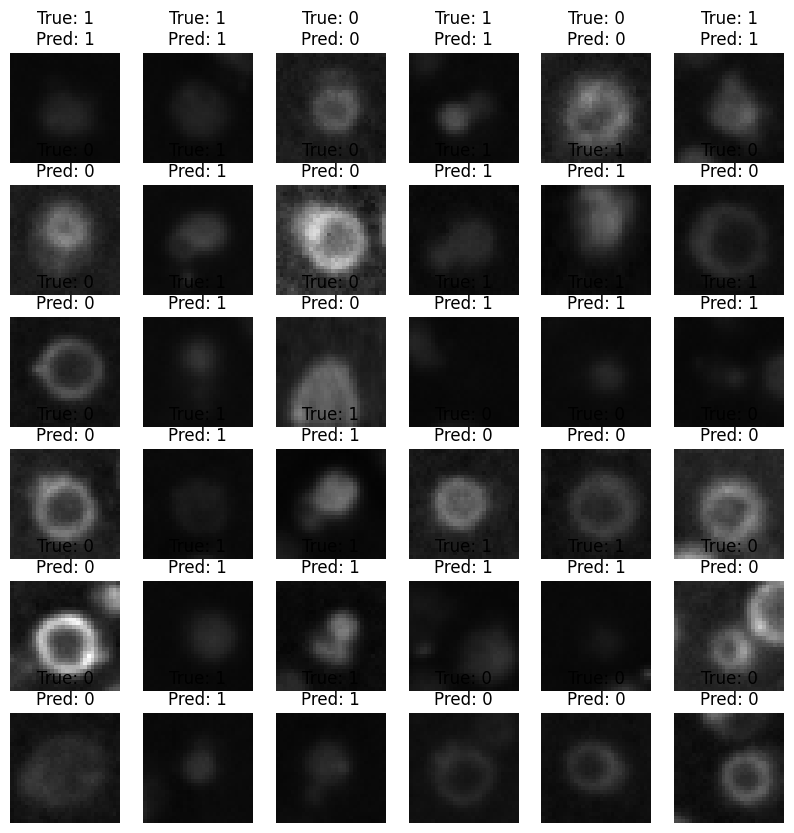

In [31]:
    
# Assuming evaluate function and model are defined elsewhere
print("Result from test data: ", evaluate(model, test_dl))

def display_images(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(36):
        plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"Label: {labels[i]}\nPred: {predictions[i]}")
        plt.axis('off')
    plt.show()

# Get a batch of test data
test_images, test_labels = next(iter(test_dl))

# Move the batch to the same device as model and calculate predictions
test_images, test_labels = test_images.to(device), test_labels.to(device)
with torch.no_grad():
    model.eval()
    outputs = model(test_images)
    _, preds = torch.max(outputs, 1)

# Assuming 'device' is the device you're using (CPU or CUDA)
test_images, test_labels, preds = test_images.cpu(), test_labels.cpu(), preds.cpu()

# Display a 6x6 grid of test images with true and predicted labels
display_images(test_images, test_labels, preds)

### Plots

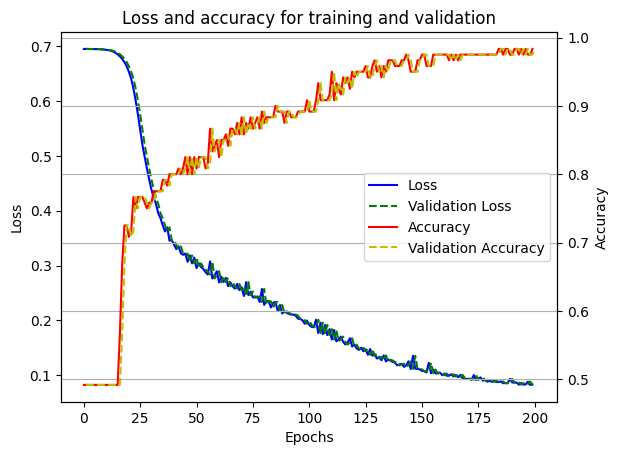

In [32]:
# Plot loss- and validation loss for each epoch
tn = np.arange(1, len(history) + 1)
fig, ax1 = plt.subplots()
ax1.plot([x['val_loss'] for x in history], 'b', label="Loss")
ax1.plot(tn, [x['val_loss'] for x in history], '--', color='g', label="Validation Loss")
ax1.set_xlabel("Epochs"), ax1.set_ylabel("Loss")

# Plot accuracy- and validation accuracy for each epoch
ax2 = ax1.twinx()
ax2.plot([x['val_acc'] for x in history], 'r', label="Accuracy")
ax2.plot(tn, [x['val_acc'] for x in history], '--', color='y', label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines+lines2, labels+labels2, loc='right')
plt.grid()
plt.title('Loss and accuracy for training and validation')
plot = plt.show()



### Save the model

In [34]:
# Define the key for the model based on the hyperparameters and time
from datetime import date
import time
key = "CNN" + batch_size.__str__() + "_" + num_epochs.__str__() + "_" + lr.__str__() + "_" + opt_func.__name__ + "_" + date.today().__str__() + "_" + device.type +  "_" + time.strftime("%H_%M_%S")
print("Model key: ", key)

# ask if the user want to save the graph using input to /Users/bastiangraver/Desktop/6.Semester/BA Project/Model_Runs
# current folder /Users/bastiangraver/Desktop/6.Semester/BA Project/Python
save = input("Do you want to save the graph? (y/n): ")
if save == "y":
    plt.savefig(f"Model_Runs/{key}.png")
    print("Graph saved as: ", key + ".png")

# ask if the user wants to save the model using input
save = input("Do you want to save the model? (y/n): ")
if save == "y":
    torch.save(model.state_dict(), f"models/{key}.pth")
    print("Model saved as: ", key + ".pth")
else:
    print("Model not saved")

Model key:  CNN64_200_1e-05_Adam_2024-03-25_mps_14_33_36
Model saved as:  CNN64_200_1e-05_Adam_2024-03-25_mps_14_33_36.pth
